In [2]:
# pycharmでjupyter notebookを使う方法
# https://blog.jetbrains.com/ja/2019/11/30/2396/

import pandas as pd
import matplotlib.pyplot as plt
# ダークモードの場合、設定しないとメモリが見えなくなる
plt.style.use('dark_background')

import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
from scipy.stats import poisson

In [3]:
df = pd.read_csv('../data/data3a.csv')
df.describe()

,y,x
count,100.000000,100.000000
mean,7.830000,10.089100
std,2.624881,1.008049
min,2.000000,7.190000
25%,6.000000,9.427500
50%,8.000000,10.155000
75%,10.000000,10.685000
max,15.000000,12.400000


In [4]:
# y: 種子数
# x: 植物のサイズ
# f: C:肥料なし, T: 肥料あり(施肥[せひ]というらしい)

df.head()

,y,x,f
0,6,8.31,C
1,6,9.44,C
2,6,9.50,C
3,12,9.07,C
4,10,10.16,C


In [5]:
# カテゴリが何件入っているか見る
df["f"].value_counts()

C    50
T    50
Name: f, dtype: int64

In [6]:
# 型確認
df.dtypes

y      int64
x    float64
f     object
dtype: object

<AxesSubplot:xlabel='x', ylabel='y'>

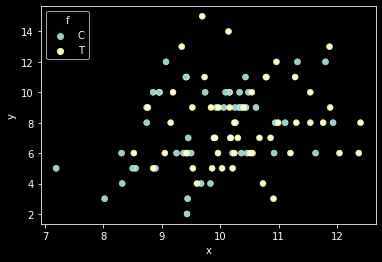

In [7]:

# 散布図
# https://engineeeer.com/pandas-dataframe-scatterplot/
sns.scatterplot(x='x', y='y', hue='f', data=df)

C         AxesSubplot(0.1,0.15;0.363636x0.75)
T    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

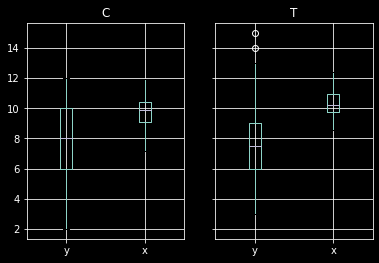

In [8]:
# 箱髭
df.groupby('f').boxplot()

<AxesSubplot:xlabel='x'>

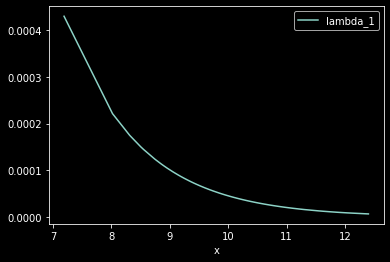

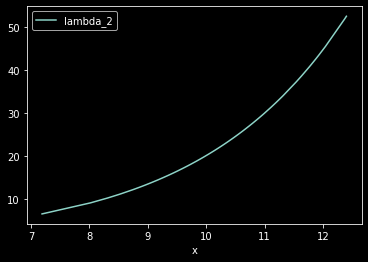

In [9]:
df_lambda = df.copy()
df_lambda['lambda_1'] = np.exp(-2 - 0.8 * df['x'])
df_lambda['lambda_2'] = np.exp(-1 + 0.4 * df['x'])
df_lambda = df_lambda.sort_values('x')
df_lambda.plot(x='x', y='lambda_1')
df_lambda.plot(x='x', y='lambda_2')

In [10]:
# https://engineeeer.com/statistical-modeling-greenbook-3b/
# interceptは切片B1, 説明変数xの係数は傾きB2に対応
# 最尤推定値はB1=1.29, B2=0.0757
# std.errorは標準誤差
# zはWald統計量と呼ばれ、最尤推定値/標準誤差。wald信頼区間と言うものが構成でき、推定値がゼロから十分に離れているかの目安らしい
fit_x = smf.poisson('y ~ x', data=df).fit()
print(fit_x)
# 最大対数尤度(当てはまりの良さ)
# Log-Likelihood:-235.39
fit_x.summary()

Optimization terminated successfully.
         Current function value: 2.353863
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                        Poisson   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Wed, 30 Sep 2020   Pseudo R-squ.:                0.009497
Time:                        23:21:23   Log-Likelihood:                -235.39
converged:                       True   LL-Null:                       -237.64
Covariance Type:            nonrobust   LLR p-value:                   0.03362
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2917      0.364      3.552      0.000       0.579       2.005
x              0.0757      0.036      2.125      0.034       0.006       0.145
==============================================================================
"""

In [11]:
# https://tnoda-journal.tumblr.com/page/3
# 最大対数尤度を求める
# これで合っているのか？あやしい
sum(poisson.logpmf(df.y, df.y))

-192.8897525244958

In [12]:
# plotにlambdaの予測値を入れる
print(df.x.min())
print(df.x.max())
arr_x = np.linspace(df.x.min(), df.x.max(), 100)
#lines = list(map(
#    lambda x: np.exp(1.29 + 0.0757 * x), arr))

# linesをpoissonに突っ込んでpredict出したいがやり方がわからない。
#

7.19
12.4


In [13]:
#https://analytics-note.xyz/programming/statsmodels-glm-poisson/
import statsmodels.api as sm
# one hot表現
df_2 = df.copy()
df_2["fT"] = (df_2.f == "T").astype(int)
y = df_2.y
X = df_2[["x", "fT"]]
X = sm.add_constant(X)
# xに特徴量、yに求めたい答えを乗っけて下記のようにmodel作る
model = sm.GLM(y, X, family=sm.families.Poisson())
result = model.fit()

# 結果出力
# 下記が最大対数尤度(当てはまりやすさ。大きい数字ほど良い)
# Log-Likelihood: -235.29
print(result.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -235.29
Date:                Wed, 30 Sep 2020   Deviance:                       84.808
Time:                        23:21:23   Pearson chi2:                     83.8
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2631      0.370      3.417      0.0

const:  1.2631050436145668
x:  0.0800726003743317
fT:  -0.031999385524744864


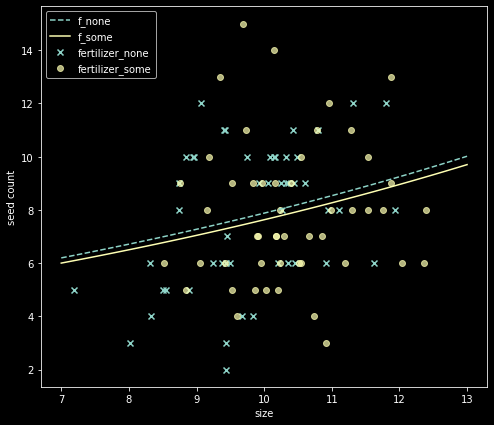

In [14]:
#B1
print("const: ", result.params["const"])
#B2
print("x: ", result.params["x"])
#B3.ほとんど施肥には意味がないことがわかる
print("fT: ", result.params["fT"])
# プロット用のデータ作成
xx = np.linspace(7, 13, 101)
yy0 = np.exp(result.params["const"] + result.params["x"]*xx)
yy1 = np.exp(result.params["const"] + result.params["x"]*xx + result.params["fT"])

fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("size")
ax.set_ylabel("seed count")
ax.scatter(X[X.fT == 0]["x"], y[X.fT == 0].values, marker="x", label="fertilizer_none")
ax.scatter(X[X.fT == 1]["x"], y[X.fT == 1].values, alpha=0.7, label="fertilizer_some")
ax.plot(xx, yy0, linestyle="--",  label="f_none")
ax.plot(xx, yy1, label="f_some")
plt.legend()
plt.show()



この結果から、サイズxiの個体iの施肥fiがCなら

`λi = exp(1.26 + 0.08xi)`

施肥がTなら

`λi = exp(1.26 + 0.08xi -0.032)`

となる。分解すると

`λi = exp(1.26) * exp(0.08xi) * exp(-0.032)`

となり、サイズが大きいほど施肥効果ありと判断できる